In [1]:
!git clone -b week10 https://github.com/vamsigp/EVA5/

Cloning into 'EVA5'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 509 (delta 71), reused 75 (delta 28), pack-reused 379
Receiving objects: 100% (509/509), 47.48 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (266/266), done.


In [2]:
%cd EVA5/trainer

/content/EVA5/trainer


In [3]:
!pip install -U albumentations

     |████████████████████████████████| 122kB 9.8MB/s 
     |████████████████████████████████| 952kB 22.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=854f8e700c52b95236e69f97f431de8fabae425f0fe37b9cb9193ff19e43db25
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
%matplotlib inline

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from config import ModelConfig
from data_engine import DataEngine
from trainer import Trainer
from results import *
from utils import *

In [6]:
from Albumentations import *
from GradCAM import *

In [7]:
# from models.cifar10 import cifar10Model
from models.resnet import ResNet18
from models.resnet_lr import ResNet18LR

In [8]:
transform_album = album_compose()

In [9]:
# View model config
args = ModelConfig(transform_album)
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 128,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1,
  'train_transform': <Albumentations.album_compose object at 0x7efc2ac7d048>}

CUDA Available


In [10]:
data = DataEngine(args)

# # get some random training images
# dataiter = iter(data.train_loader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images[:4]))
# # print labels
# print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
device = which_device()
# model = ResNet18().to(device)

# show_model_summary(model, device, (3,32,32))

In [12]:
!pip install torch-lr-finder

In [13]:
# from torch_lr_finder import LRFinder
# from torch.optim.lr_scheduler import ReduceLROnPlateau

In [14]:
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim


def get_best_lr_sgd(model, trainloader, lr=1e-7, momentum=0.9, end_lr=100, num_iter=100):
    """
    Tweaked version from fastai
    
    Increases the learning rate in an exponential manner and computes the training loss for each learning rate. 
    lr_finder.plot() plots the training loss versus logarithmic learning rate.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(trainloader, end_lr=end_lr, num_iter=num_iter)
    lr_finder.plot() # to inspect the loss-learning rate graph
    return lr_finder

/content/EVA5/trainer/models/resnet_lr.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.11E-02


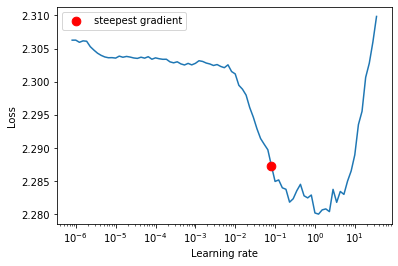

In [16]:
model_lr = ResNet18LR().to(device)

get_best_lr_sgd(model_lr, data.train_loader)

In [ ]:
# for i in range(1,16):
#   model = ResNet18().to(device)
#   criterion = nn.CrossEntropyLoss()
#   optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
  
#   lr_finder = LRFinder(model, optimizer, criterion, device=device)
#   lr_finder.range_test(data.train_loader, end_lr=100, num_iter=100, step_mode="exp")
#   lr_finder.plot()
#   lr_finder.reset()



In [17]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

In [18]:
model = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=6.58E-02, momentum=0.9, weight_decay=0.001)

# scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=20)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [19]:
trainer = Trainer(model, 
                  device,
                  train_loader=data.train_loader, 
                  test_loader = data.test_loader, 
                  optimizer = optimizer, 
                  loss_func = criterion, 
                  lr_scheduler = scheduler) 

In [20]:
# (train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)

  0%|          | 0/391 [00:00<?, ?it/s]


Current EPOCH: 0
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=3.3440701961517334 Batch_id=390 Accuracy=28.26: 100%|██████████| 391/391 [00:56<00:00,  6.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 3451/10000 (34.51%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.014089708340167999

Current EPOCH: 1
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=2.5282552242279053 Batch_id=390 Accuracy=36.60: 100%|██████████| 391/391 [00:57<00:00,  6.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 3768/10000 (37.68%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.01342564035654068

Current EPOCH: 2
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=2.4930009841918945 Batch_id=390 Accuracy=42.26: 100%|██████████| 391/391 [00:57<00:00,  6.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 4325/10000 (43.25%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.012740383541584015

Current EPOCH: 3
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=2.1707868576049805 Batch_id=390 Accuracy=48.15: 100%|██████████| 391/391 [00:57<00:00,  6.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 5535/10000 (55.35%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.00974085133075714

Current EPOCH: 4
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.7737911939620972 Batch_id=390 Accuracy=52.20: 100%|██████████| 391/391 [00:57<00:00,  6.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 5933/10000 (59.33%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.008871930706501007

Current EPOCH: 5
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.760671615600586 Batch_id=390 Accuracy=54.28: 100%|██████████| 391/391 [00:57<00:00,  6.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 5712/10000 (57.12%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.009388805574178696

Current EPOCH: 6
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.6868176460266113 Batch_id=390 Accuracy=55.85: 100%|██████████| 391/391 [00:56<00:00,  6.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 6063/10000 (60.63%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.009034367340803146

Current EPOCH: 7
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.402552604675293 Batch_id=390 Accuracy=57.36: 100%|██████████| 391/391 [00:56<00:00,  6.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 5792/10000 (57.92%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.009730163884162903

Current EPOCH: 8
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.3832333087921143 Batch_id=390 Accuracy=58.67: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6295/10000 (62.95%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.00827528687119484

Current EPOCH: 9
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.6280333995819092 Batch_id=390 Accuracy=58.86: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6256/10000 (62.56%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.008832015454769134

Current EPOCH: 10
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.260667324066162 Batch_id=390 Accuracy=59.44: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6138/10000 (61.38%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.008761545944213868

Current EPOCH: 11
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.574623465538025 Batch_id=390 Accuracy=59.67: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 5751/10000 (57.51%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.010180667436122894

Current EPOCH: 12
Learning Rate(ReduceLROnPlateau) =  0.0658


Train set: Loss=1.2546348571777344 Batch_id=390 Accuracy=60.17: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 5855/10000 (58.55%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.009514276617765426

Current EPOCH: 13
Learning Rate(ReduceLROnPlateau) =  0.01316


Train set: Loss=1.1718904972076416 Batch_id=390 Accuracy=67.04: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7468/10000 (74.68%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.005743962424993515

Current EPOCH: 14
Learning Rate(ReduceLROnPlateau) =  0.01316


Train set: Loss=1.2007020711898804 Batch_id=390 Accuracy=68.37: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7388/10000 (73.88%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.005827661603689194

Current EPOCH: 15
Learning Rate(ReduceLROnPlateau) =  0.01316


Train set: Loss=1.087294101715088 Batch_id=390 Accuracy=68.83: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7651/10000 (76.51%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0053366133749485015

Current EPOCH: 16
Learning Rate(ReduceLROnPlateau) =  0.01316


Train set: Loss=1.0225679874420166 Batch_id=390 Accuracy=68.87: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7417/10000 (74.17%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0057921097189188005

Current EPOCH: 17
Learning Rate(ReduceLROnPlateau) =  0.01316


Train set: Loss=1.2697534561157227 Batch_id=390 Accuracy=69.08: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7286/10000 (72.86%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.006139606672525406

Current EPOCH: 18
Learning Rate(ReduceLROnPlateau) =  0.01316


Train set: Loss=1.1372883319854736 Batch_id=390 Accuracy=68.79: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7374/10000 (73.74%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0059795449852943425

Current EPOCH: 19
Learning Rate(ReduceLROnPlateau) =  0.01316


Train set: Loss=1.138709545135498 Batch_id=390 Accuracy=68.91: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7644/10000 (76.44%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.005344473093748092

Current EPOCH: 20
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=0.8352726697921753 Batch_id=390 Accuracy=72.36: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7953/10000 (79.53%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.004597525501251221

Current EPOCH: 21
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=1.0069243907928467 Batch_id=390 Accuracy=73.38: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8075/10000 (80.75%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.004443338152766227

Current EPOCH: 22
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=0.9569872617721558 Batch_id=390 Accuracy=73.90: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8072/10000 (80.72%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.004389287094771862

Current EPOCH: 23
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=1.2273139953613281 Batch_id=390 Accuracy=74.33: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8075/10000 (80.75%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.004434143179655075

Current EPOCH: 24
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=0.727895975112915 Batch_id=390 Accuracy=74.14: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8108/10000 (81.08%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0043548742711544035

Current EPOCH: 25
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=1.104197382926941 Batch_id=390 Accuracy=74.17: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8063/10000 (80.63%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0045274506717920306

Current EPOCH: 26
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=1.0263864994049072 Batch_id=390 Accuracy=74.51: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8098/10000 (80.98%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0043520642548799515

Current EPOCH: 27
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=0.8644276857376099 Batch_id=390 Accuracy=74.43: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8068/10000 (80.68%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.004436143663525582

Current EPOCH: 28
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=0.9681370854377747 Batch_id=390 Accuracy=74.70: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8091/10000 (80.91%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.004399207693338394

Current EPOCH: 29
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=1.046402096748352 Batch_id=390 Accuracy=74.48: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8096/10000 (80.96%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.00439471749663353

Current EPOCH: 30
Learning Rate(ReduceLROnPlateau) =  0.0026320000000000002


Train set: Loss=0.8322495818138123 Batch_id=390 Accuracy=74.71: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8027/10000 (80.27%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.004495384049415589

Current EPOCH: 31
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.8845719695091248 Batch_id=390 Accuracy=76.44: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8283/10000 (82.83%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0039668526083230975

Current EPOCH: 32
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.9566413164138794 Batch_id=390 Accuracy=76.74: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8331/10000 (83.31%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0039020315170288085

Current EPOCH: 33
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.6533699631690979 Batch_id=390 Accuracy=76.98: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8327/10000 (83.27%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003840154492855072

Current EPOCH: 34
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.7167603969573975 Batch_id=390 Accuracy=77.16: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8277/10000 (82.77%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003988975721597672

Current EPOCH: 35
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.9262033700942993 Batch_id=390 Accuracy=77.04: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8331/10000 (83.31%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003826552551984787

Current EPOCH: 36
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.7134802937507629 Batch_id=390 Accuracy=77.13: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8318/10000 (83.18%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0038169892698526383

Current EPOCH: 37
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.8014155626296997 Batch_id=390 Accuracy=77.19: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8367/10000 (83.67%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003775630870461464

Current EPOCH: 38
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.8424111008644104 Batch_id=390 Accuracy=77.66: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8351/10000 (83.51%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0037585325062274933

Current EPOCH: 39
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.8911141753196716 Batch_id=390 Accuracy=77.20: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8325/10000 (83.25%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0038389262318611144

Current EPOCH: 40
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.7871730327606201 Batch_id=390 Accuracy=77.34: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8404/10000 (84.04%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0037311997830867766

Current EPOCH: 41
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.7219609618186951 Batch_id=390 Accuracy=77.57: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8364/10000 (83.64%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003758834284543991

Current EPOCH: 42
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.7246653437614441 Batch_id=390 Accuracy=77.76: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8325/10000 (83.25%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.00384498091340065

Current EPOCH: 43
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.7691771984100342 Batch_id=390 Accuracy=77.71: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8312/10000 (83.12%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0038786919087171554

Current EPOCH: 44
Learning Rate(ReduceLROnPlateau) =  0.0005264000000000001


Train set: Loss=0.8291316032409668 Batch_id=390 Accuracy=77.86: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8355/10000 (83.55%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0037398496508598326

Current EPOCH: 45
Learning Rate(ReduceLROnPlateau) =  0.00010528000000000002


Train set: Loss=0.9025251269340515 Batch_id=390 Accuracy=78.20: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8402/10000 (84.02%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003673923605680466

Current EPOCH: 46
Learning Rate(ReduceLROnPlateau) =  0.00010528000000000002


Train set: Loss=0.941533088684082 Batch_id=390 Accuracy=78.12: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8442/10000 (84.42%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003629804155230522

Current EPOCH: 47
Learning Rate(ReduceLROnPlateau) =  0.00010528000000000002


Train set: Loss=0.8826910853385925 Batch_id=390 Accuracy=78.34: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8380/10000 (83.80%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003722007840871811

Current EPOCH: 48
Learning Rate(ReduceLROnPlateau) =  0.00010528000000000002


Train set: Loss=0.9854153990745544 Batch_id=390 Accuracy=78.46: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8426/10000 (84.26%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.003627431216835976

Current EPOCH: 49
Learning Rate(ReduceLROnPlateau) =  0.00010528000000000002


Train set: Loss=0.7477579116821289 Batch_id=390 Accuracy=78.20: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]



Test set: Average loss: 0.0036, Accuracy: 8434/10000 (84.34%)

ReduceLROnPlateau, ReduceLROnPlateau::step(), val_loss 0.0036452473878860474


In [21]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

In [22]:
trainer.classwise_acc(classes)


Accuracy of plane : 82 %
Accuracy of   car : 89 %
Accuracy of  bird : 70 %
Accuracy of   cat : 65 %
Accuracy of  deer : 83 %
Accuracy of   dog : 74 %
Accuracy of  frog : 96 %
Accuracy of horse : 90 %
Accuracy of  ship : 84 %
Accuracy of truck : 89 %



In [23]:
misclassified_imgs = trainer.get_misclassified()

/content/EVA5/trainer/trainer.py:148: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_inds = (is_correct == 0).nonzero()[:, 0]


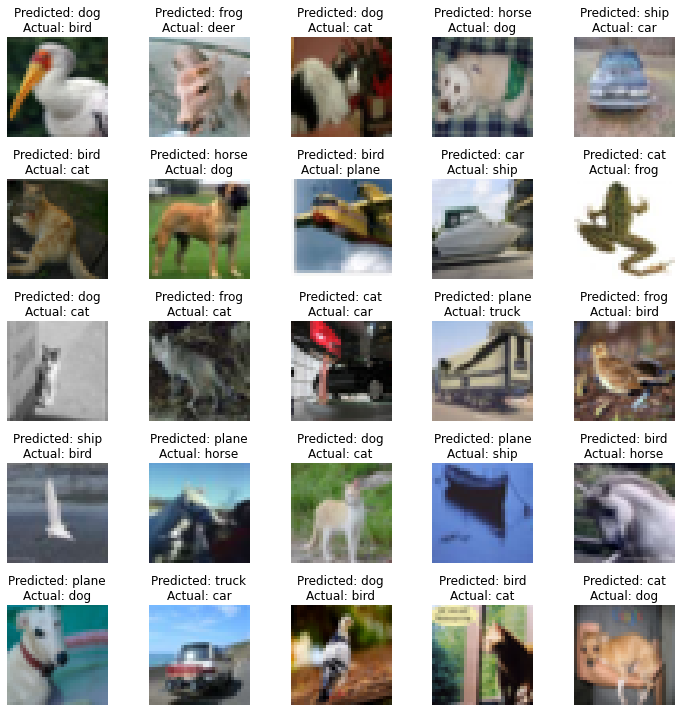

In [24]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_images1.png")

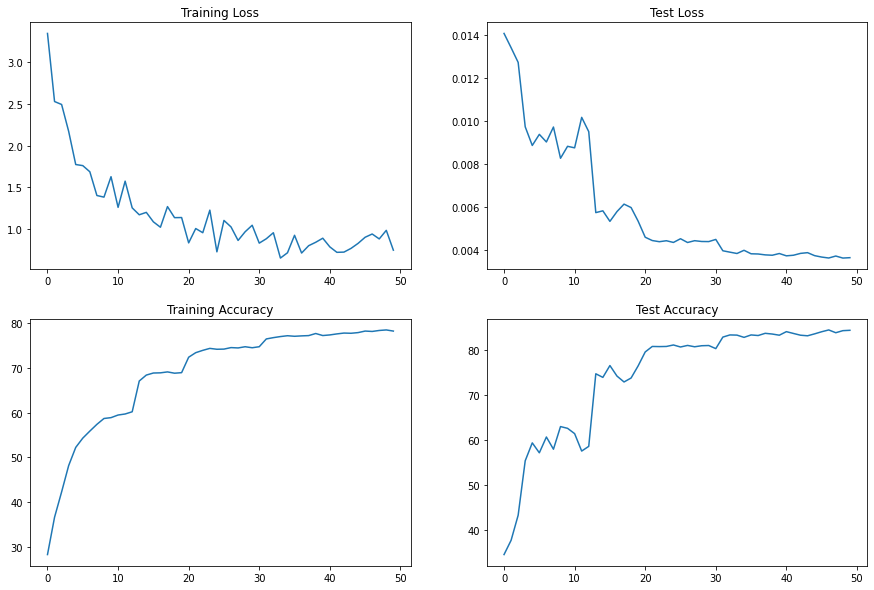

In [25]:
from results import plot_metrics
plot_metrics(train_loss, train_acc, test_loss, test_acc)

In [26]:
### GradCam

In [27]:
dataiter = iter(data.test_loader)
images, labels = dataiter.next()

In [28]:
import PIL
import numpy as np

In [29]:
# model.convblock

In [30]:
for name, layer in model.named_modules():
  if isinstance(layer, torch.nn.Conv2d):
    print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.conv1 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer2.0.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.shortcut.0 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
layer2.1.conv1 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.1.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.0.conv1 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), 

In [31]:
def plot_images_gradcam(torch_img,normed_torch_img, model):
    images=[]
    g1 = GradCAM(model, model.layer1)
    g2 = GradCAM(model, model.layer2)
    g3 = GradCAM(model, model.layer3)
    g4 = GradCAM(model, model.layer4)
    mask1, _ = g1(normed_torch_img)
    mask2, _ = g2(normed_torch_img)
    mask3, _ = g3(normed_torch_img)
    mask4, _ = g4(normed_torch_img)
    heatmap1, result1 = visualize_cam(mask1, torch_img)
    heatmap2, result2 = visualize_cam(mask2, torch_img)
    heatmap3, result3 = visualize_cam(mask3, torch_img)
    heatmap4, result4 = visualize_cam(mask4, torch_img)

    images.extend([torch_img.cpu(), heatmap1, heatmap2, heatmap3, heatmap4])
    images.extend([torch_img.cpu(), result1, result2, result3, result4])
    grid_image = make_grid(images, nrow=5)
    imshow(grid_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


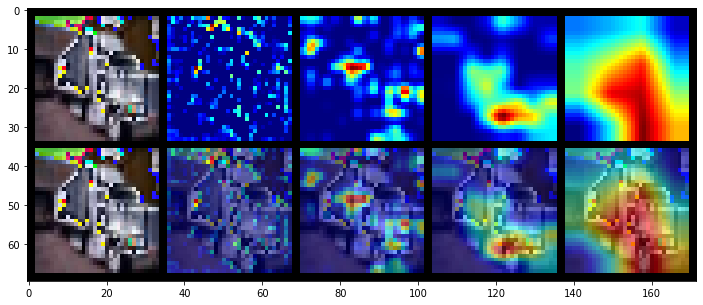

In [32]:
trans = transforms.ToPILImage()
pil_img=trans(torchvision.utils.make_grid(images[1]))
torch_img,normed_torch_img=change(pil_img,device)
plot_images_gradcam(torch_img,normed_torch_img, model)